In [1]:
#import modules
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np

In [2]:
data = pd.read_excel("Online_Retail.xlsx")

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print(data.shape)

(541909, 8)


In [5]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

In [6]:
print(filtered_data.shape)

(4389, 2)


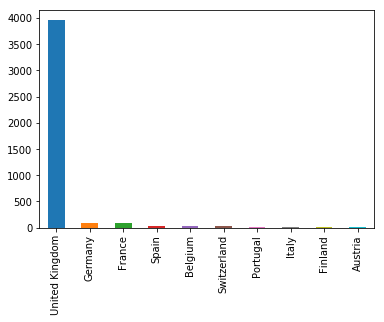

In [7]:
#Data Insights
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [8]:
uk_data=data[data.Country=='United Kingdom']
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null datetime64[ns]
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 34.0+ MB


In [9]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


## Removing customers who have ordered in a negative quantity

In [10]:
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      486286 non-null object
StockCode      486286 non-null object
Description    485694 non-null object
Quantity       486286 non-null int64
InvoiceDate    486286 non-null datetime64[ns]
UnitPrice      486286 non-null float64
CustomerID     354345 non-null float64
Country        486286 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.4+ MB


## We need only five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice. We can omit remaining columns.

In [11]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [12]:
#Calulate total purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice']

## Calculate the number of days between the present date and the date of last purchase from each customer.
## Calculate the number of orders for each customer.
## Calculate sum of purchase price for each customer.

In [13]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPurchase': lambda price: price.sum()})

In [14]:
print(uk_data_group.shape)
uk_data_group.head()

(3921, 4)


,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


In [15]:
# Change the name of columns
uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,366,103,1275,4196.01
12748.0,372,4596,25748,33719.73
12749.0,209,199,1471,4090.88
12820.0,323,59,722,942.34


## Calculate CLTV using following formula:
## CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

## Customer Value = Average Order Value * Purchase Frequency

In [16]:
# Average Order Value
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']

In [17]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12747.0,366,103,1275,4196.01,40.737961
12748.0,372,4596,25748,33719.73,7.336756
12749.0,209,199,1471,4090.88,20.557186
12820.0,323,59,722,942.34,15.971864


In [18]:
# Calculate Purchase Frequency
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

In [19]:
# Calculate Repeat Rate and Churn Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]

In [20]:
#Churn Rate
churn_rate=1-repeat_rate

In [21]:
purchase_frequency,repeat_rate,churn_rate

(90.37107880642694, 0.9818923743942872, 0.018107625605712774)

In [22]:
# Profit Margin
uk_data_group['profit_margin']=uk_data_group['spent_money']*0.05

In [23]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800
12747.0,366,103,1275,4196.01,40.737961,209.8005
12748.0,372,4596,25748,33719.73,7.336756,1685.9865
12749.0,209,199,1471,4090.88,20.557186,204.5440
12820.0,323,59,722,942.34,15.971864,47.1170


In [24]:
#Calcualte Customer Lifetime Value
# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate
#Customer Lifetime Value
uk_data_group['cust_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,366,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,372,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,209,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07
12820.0,323,59,722,942.34,15.971864,47.1170,7.971198e+04,3.755789e+06


### Prediction Model for CLTV. Here we will predict the CLTV using Linear regression model.

In [25]:
#Let's first use the data loaded and filtered above.
uk_data.head()


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [26]:
#Extract month and year from InvoiceDate.
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
uk_data.head()
#uk_data[uk_data.CustomerID == 12346.0]
#uk_data[uk_data.CustomerID == 12747.0]

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_yr
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30,Dec-2010
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00,Dec-2010
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34,Dec-2010


## The below pivot table calculates monthly expenses based on/group by Customer ID

In [27]:
sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77


In [28]:
# sum all the months sales.
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,77183.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,77183.60
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,898.24,4228.13,1070.27,389.64,418.77,1113.27,2006.26,1179.37,2234.50,10639.23,2292.84,6148.84,32619.36
3,12749.0,0.00,1896.13,0.00,763.06,0.00,0.00,0.00,0.00,0.00,859.10,572.59,0.00,0.00,4090.88
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


In [29]:
# Saving these details for final submission.
X1=sale[['CustomerID','Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y1=sale[['CLV']]
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,random_state=0)

In [30]:
# Divide above data into dependent and independent variable.
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]

In [31]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [32]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [33]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[208.50969617]
[[0.99880551 0.80381254 1.60226829 1.67433228 1.52860813 2.87959449]]


In [34]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.9666074402817513


In [35]:
#Model Evaluation
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 595.0282284701236
MSE 2114139.889867891
RMSE: 1454.008215199588


In [36]:
print(X_test.shape)
X_test.head()

(981, 6)


month_yr,Dec-2011,Nov-2011,Oct-2011,Sep-2011,Aug-2011,Jul-2011
538,0.0,0.00,0.00,0.00,0.0,0.0
3000,0.0,415.18,0.00,0.00,340.9,0.0
825,0.0,462.44,500.21,1261.81,0.0,0.0
924,62.5,643.63,0.00,0.00,0.0,0.0
3093,0.0,0.00,0.00,0.00,0.0,0.0


In [37]:
print(X1_test.shape)
X1_test.head()

(981, 7)


month_yr,CustomerID,Dec-2011,Nov-2011,Oct-2011,Sep-2011,Aug-2011,Jul-2011
538,13570.0,0.0,0.00,0.00,0.00,0.0,0.0
3000,16996.0,0.0,415.18,0.00,0.00,340.9,0.0
825,13988.0,0.0,462.44,500.21,1261.81,0.0,0.0
924,14126.0,62.5,643.63,0.00,0.00,0.0,0.0
3093,17128.0,0.0,0.00,0.00,0.00,0.0,0.0


In [38]:
print(y_pred.shape)
pd.DataFrame(y_pred).head()

(981, 1)


,0
0,208.509696
1,1063.339100
2,3494.384605
3,788.292906
4,208.509696


## Writing The Test Data + Predicted Column Into CSV File

In [39]:
df1 = pd.DataFrame(X1_test)
df2 = pd.DataFrame(y_pred)
submission = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
submission.to_csv('submission.csv', index=False)
submission.head()

,CustomerID,Dec-2011,Nov-2011,Oct-2011,Sep-2011,Aug-2011,Jul-2011,0
0,13570.0,0.0,0.00,0.00,0.00,0.0,0.0,208.509696
1,16996.0,0.0,415.18,0.00,0.00,340.9,0.0,1063.339100
2,13988.0,0.0,462.44,500.21,1261.81,0.0,0.0,3494.384605
3,14126.0,62.5,643.63,0.00,0.00,0.0,0.0,788.292906
4,17128.0,0.0,0.00,0.00,0.00,0.0,0.0,208.509696
